# Transfer Learning
-----------------------

In this notebook, parts of the Fruits and Vegetables dataset is used. The original dataset can be downloaded from Kaggle: 

https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

A subset of the dataset is used here, and can be accessed via the following link: 

https://seafile.ifi.uzh.ch/f/72e1d9c4ef20420eb1d9/?dl=1

In [1]:
import os
dataset_zip_file = "fruits.zip"
if not os.path.exists(dataset_zip_file):
  import urllib.request
  urllib.request.urlretrieve("https://seafile.ifi.uzh.ch/f/72e1d9c4ef20420eb1d9/?dl=1", dataset_zip_file)
  print ("Downloaded datafile", dataset_zip_file)
  import zipfile
  zipfile.ZipFile(dataset_zip_file).extractall()

## Data Transformation

A proper `torchvision.transform` instance need to be instantiated to create the same input structure as used for training the network.

We need to combine 4 transforms, which can be compiled from the PyTorch website: https://pytorch.org/vision/stable/models.html

1. We need to resize the image such that the shorter side has size 256.
2. We need to take the center crop of size $224\times224$ from the image.
3. We need to convert the image into a tensor (including pixel values scaling)
4. We need to normalize the pixel values with mean $(0.485, 0.456, 0.406)$ and standard deviation $(0.229, 0.224, 0.225)$

Since we will use networks pre-trained on ImageNet, we need to perform the exact same transform as used for ImageNet testing.

In [2]:
import torch
import torchvision

imagenet_transform = torchvision.transforms.Compose([
  torchvision.transforms.Resize(256), # If size is an int, smaller edge of the image will be matched to this number
  torchvision.transforms.CenterCrop(224), # If size is an int instead of sequence like (h, w), a square crop (size, size) is made
  torchvision.transforms.ToTensor(), # convert to torch.tensor and scale pixel vals to be in [0, 1]
  torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # normalization by subtracting mean(0.485,0.456,0.406) and dividing by variance(0.229,0.224,0.225)
])

## Dataset Loading

We here use the `torchvision.datasets.ImageFolder` dataset interface for processing images. 
Its documented `is_valid_file` parameter can be used to distinguish between training and test set.
The training files are all called `gallery.jpg` while test files are called `probe.jpg`.

Create two datasets, one for the training set, one for the test set. Use the transform defined above.

In [3]:
trainset = torchvision.datasets.ImageFolder(
  root = "fruits",
  transform=imagenet_transform,
  is_valid_file=lambda x: "gallery" in x
)

testset = torchvision.datasets.ImageFolder(
  root = "fruits",
  transform=imagenet_transform,
  is_valid_file=lambda x: "probe" in x
)

## Test Data Size and Types

Check that all datasets contain the same number of images as classes.
Check that all input images are `torch.tensor`s of size $3\times224\times224$ and of type `torch.float`.


In [4]:
assert(len(trainset) == len(testset))
for x, t in trainset + testset:
  assert isinstance(x, torch.Tensor)
  assert x.shape == (3, 224, 224)
  assert x.dtype == torch.float

## Pre-trained Network

Instantiate a pre-trained network of type ResNet-18. 
Modify the network such that the deep features from before the last fully-connected layer of the network are extracted.

Note: while we modify the `forward` function, we will still use the `__call__` function to extract the features.

In [ ]:
# instantiate pre-trained resnet 18 network
network = torchvision.models.resnet18(pretrained = True)
network.eval()

# make sure that deep features can be etxracted from the network
network = torch.nn.Sequential(*(list(network.children())[:-1]))

## Extract Features

Implement a function that extracts all features for a given dataset.
Store the results in a dictionary: `target : feature`.
Extract the features for the training and the test set.

In [6]:
def extract(network, dataset):
  features = {}
  for tensor_data,index in dataset:
    features[index]=network(torch.unsqueeze(tensor_data,0))
  return features

train_features = extract(network,trainset)
test_features = extract(network,testset)

Check the Features
---------------------------

Check that all features are of dimension 512 and of datatype `torch.float`.

In [7]:
# check features
for feature_dict in [train_features, test_features]:
  for c, f in feature_dict.items():
    assert(f.shape[1] == 512) # check if feature dimension is 512
    assert(f.dtype == torch.float) # check datatype

## Similarity Computation

Iterate over all samples in the test set.
Compute the cosine similarities to all samples in the training set.
Store the similarity values in a matrix.

In [8]:
O = len(testset)
similarities = torch.empty((O, O))

cos = torch.nn.CosineSimilarity()
# compute similarities
for row in range(O):
  for col in range(O):
    similarities[row][col] = cos(test_features[row],train_features[col])

## Plot Similarity Values

Plot the similarity matrix as an image.

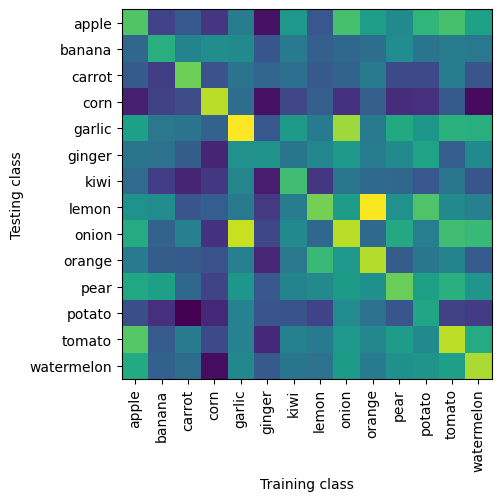

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# plot similarities
plt.imshow(similarities.detach().numpy())
classnames = sorted(os.listdir('fruits/'))
plt.xticks(np.arange(len(classnames)), classnames, rotation=90)
plt.yticks(np.arange(len(classnames)), classnames)
plt.xlabel('Training class')
plt.ylabel('Testing class')
plt.show()

## Classification Accuracy

Compute the classification accuracy by checking if the class of highest similarity for a test sample is the correct class.

In [21]:
# compute accuracy for our small test set
same = torch.argmax(similarities, dim=1) == torch.tensor(list(test_features.keys()))
accuracy = sum(same) / len(same)
print("Accuracy is", round(accuracy.item(),3))

Accuracy is 0.786


##  Misclassified Images and Classes

Find the test samples that are incorrectly classified. 
Get the class names and write the names of the test sample class as well as the class that it was classified as.

In [12]:
classnames = testset.classes

# find all misclassified test images and print their real and predicted class name
predicted_class_idx = np.argmax(similarities.detach().numpy(), axis = 0)
predicted_class_names = [classnames[idx] for idx in predicted_class_idx]
class_indicator = np.equal(predicted_class_idx, testset.targets) == 1
for i in range(len(testset.targets)):
  if not class_indicator[i]:
    print (f'{classnames[i]} is misclassified as {predicted_class_names[i]}')

print('-------------\n')

# find the pair of most dissimilar training and test class and print their names
idx = np.argmin(similarities.detach().numpy())
row = idx // len(testset.targets)
col = idx % len(testset.targets)
print (f'The most dissimilar classes are {classnames[row]} and {classnames[col]}')

apple is misclassified as tomato
orange is misclassified as lemon
potato is misclassified as lemon
-------------

The most dissimilar classes are potato and carrot
